### This exercise is to create a CNN model that will help predict the presence of Melanoma, based on input images. Melanoma which is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### We will use a dataset of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images are sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

## During this exercise, we will try to capture the importance of sample size distribution, impact or skew in class distribution and computational viability to keep in mind while creating an optimum CNN model.

#### For more information, refer the README.md file.

Let us import the standard libraries I can think of for now. We will pull in other as we go along.

In [3]:


import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings("ignore")
     


In [9]:
!pip show pathlib

Name: pathlib
Version: 1.0.1
Summary: Object-oriented filesystem paths
Home-page: https://pathlib.readthedocs.org/
Author: Antoine Pitrou
Author-email: solipsis@pitrou.net
License: MIT License
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: 


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

Here I unzip the folder from my Google drive.

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')
!unzip "/content/gdrive/MyDrive/Melanoma_Detection_CNN.zip" > /dev/null

Mounted at /content/gdrive


If you are using a local copy of the dataset, change the path names accordingly.

In [ ]:
# Path to the images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")



Count of the number of samples in the train and test datasets

In [ ]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Now we initialize the global parameters we use. As stated in the problem statement we will use a batch size of 32 and resize the images to 180 * 180 pixels

In [ ]:



batch_size = 32
img_height = 180
img_width = 180
     


Define the train dataset using the image size and batch sizes from the global parameters, using 80% of the samples.

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=batch_size,
                                                               image_size=(img_height,img_width),
                                                               label_mode='categorical',
                                                               subset="training",
                                                               validation_split=0.2,
                                                               seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Define the validation dataset using the image size and batch sizes from the global parameters, using 20% of the samples.

In [ ]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             batch_size=batch_size,
                                                             image_size=(img_height,img_width),
                                                             label_mode='categorical',
                                                             subset="validation",
                                                             validation_split=0.2,
                                                             seed=123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


List out all the categories present in the sample and how many categories we have in total

In [ ]:

class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


Look at one sample for each category from the dataset.

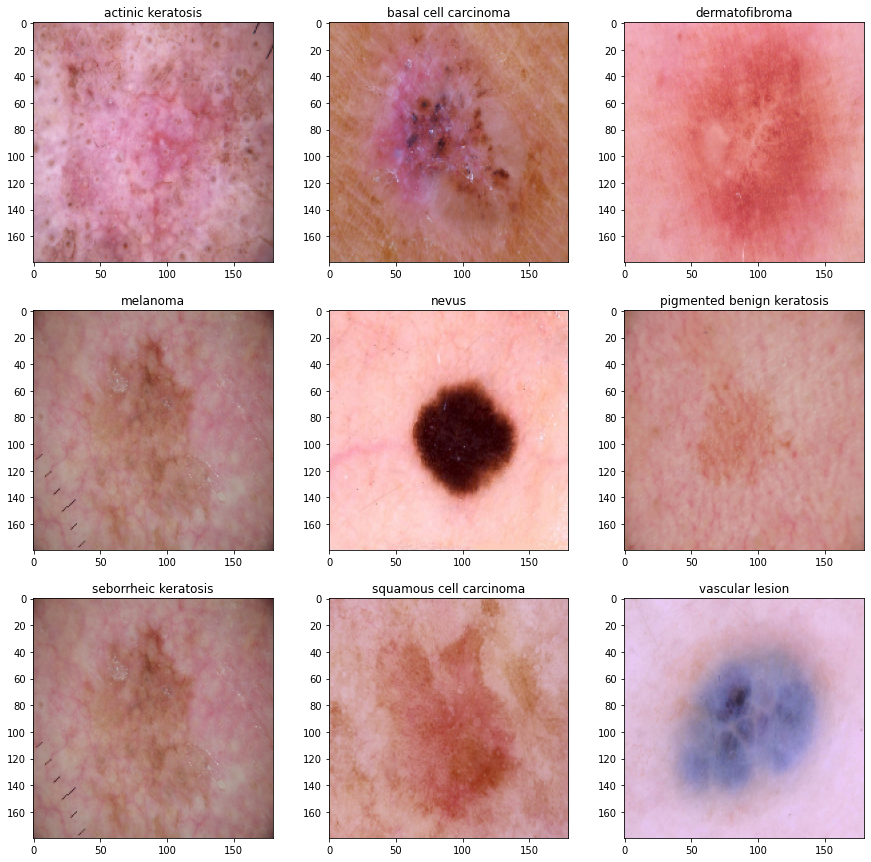

In [ ]:

dic_filepath = {}

for cls in class_names:
    dic_filepath[cls] = list(map(lambda x:str(data_dir_train)+'/'+ cls +'/'+x,os.listdir(str(data_dir_train)+'/' + cls)))
    

plt.figure(figsize=(15,15))
index = 0
for cls in class_names:
    path_list = dic_filepath[cls][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(cls)

Autotune is used to find the number of layers to be fine-tuned automatically for a target dataset for improved learning.

In [ ]:


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
     


Now we will create the first model. We will use a filter size of 3 * 3. We will use 3 convolutional layers and 2 dense layers with ReLU activation and finally the softmax layer to categorize the input into 1 of the 9 classes. We will also rescale the image pixel values to 255th the original size (each pixel can have a value from 0 to 255). This is in order to make the computations faster.

In [ ]:
ishape = (img_height,img_width,3)

m1 = Sequential()    

# 1st Convolutional layer
m1.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=ishape))
m1.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
m1.add(layers.MaxPool2D(pool_size=(2,2)))

# 2nd Convolutional layer
m1.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
m1.add(layers.MaxPool2D(pool_size=(2,2)))

# 3rd Convolutional layer
m1.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
m1.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten out the incoming tensors into one vector
m1.add(layers.Flatten())   

# 1st Dense layer
m1.add(layers.Dense(512,activation='relu'))

# 2nd Dense layer
m1.add(layers.Dense(128,activation='relu'))

# Softmax layer
m1.add(layers.Dense(len(class_names),activation='softmax'))

Compile the model using Adam optimizer. According to Google The results of the Adam optimizer are generally better than every other optimization algorithm, have faster computation time, and require fewer parameters for tuning. Also, we will use the Categorical Cross-Entropy loss function as it is suited for multiple classes (there are 9 here)

In [ ]:

m1.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

View the summary of all the layers

In [ ]:

m1.summary()



Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 41, 41, 128)      

Now, we will train the model with 20 epochs. Since this is a very complex and long running computation sweep, I have used Google GPU option. What originally took around 2 hours on my local machine was completed in around 5 minutes using GPU. However, it comes at a cost and the Colab Pro subscription comes with 100 computation units per month. So, be careful of what you really want to run on the GPU. Check the syntaxes before running too, as a command in error also takes up computation units.

In [ ]:
# Train the model with 20 epochs

epochs = 20
history = m1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 15ms/step - loss: 2.1320 - accuracy: 0.1886 - val_loss: 2.0138 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 1s 12ms/step - loss: 1.8231 - accuracy: 0.3555 - val_loss: 1.5419 - val_accuracy: 0.4698
Epoch 3/20
56/56 [==============================] - 1s 12ms/step - loss: 1.5107 - accuracy: 0.4581 - val_loss: 1.4134 - val_accuracy: 0.4989
Epoch 4/20
56/56 [==============================] - 1s 12ms/step - loss: 1.4527 - accuracy: 0.4894 - val_loss: 1.5320 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 1s 12ms/step - loss: 1.3959 - accuracy: 0.5039 - val_loss: 1.4607 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 1s 12ms/step - loss: 1.3037 - accuracy: 0.5346 - val_loss: 1.6131 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 1s 12ms/step - loss: 1.2964 - accuracy: 0.5430 - val_loss: 1.4379 - val_accuracy: 0.4720
Epoch 8/20
56

The training accuracy is at 90.4% where as the validation accuracy was only 50.5. This is an indication of overfitting. Let's see these results visually.

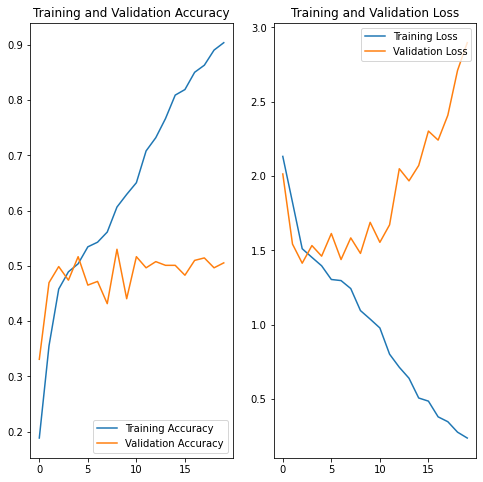

In [ ]:
# Visualizing training results


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
     


As we can see, the model is clearly overfitting, evidenced by the huge difference between the training and validation accuracies. Now let's try an augmentation strategy of morphing the images by resizing, flipping and rotating them to see if the model performs any better.

In [ ]:
# Here we will try different strategies like rescaling, flipping horizontally and vertically, zooming in and rotating the image.

rescale = tf.keras.Sequential([ 
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

Now let's view one image from the morphed lot to see if we have the desired results from the above morphing steps.

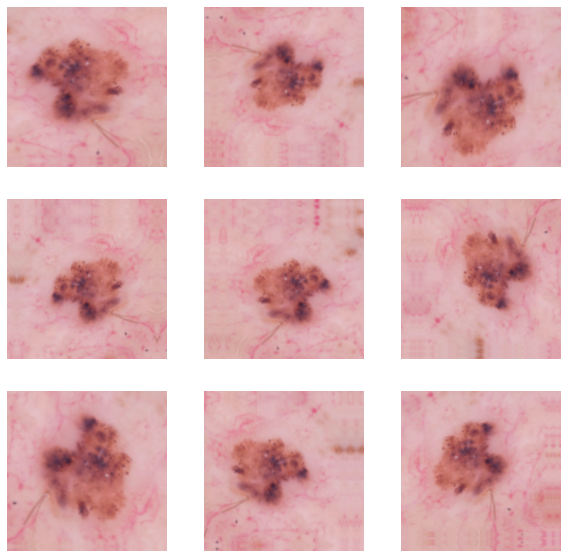

In [ ]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")                       



As we can see from the one sample image above, we have different variations of the same image. Let's try and build a new model with the newly created morphed data. We will also all dropouts in this step as that too can help mitigate overfitting.

In [ ]:

m2 = Sequential()

m2.add(data_augmentation)           
m2.add(rescale)         

# 1st Convolutional layer
m2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
m2.add(layers.MaxPool2D(pool_size=(2,2)))
m2.add(layers.Dropout(0.25))

# 2nd Convolutional layer
m2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
m2.add(layers.MaxPool2D(pool_size=(2,2)))
m2.add(layers.Dropout(0.25))

# 3rd Convolutional layer
m2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
m2.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten out the incoming tensors into a single vector
m2.add(layers.Flatten())

# 1st Dense layer
m2.add(layers.Dense(512,activation='relu'))

# 2nd Dense layer
m2.add(layers.Dense(128,activation='relu'))
m2.add(layers.Dropout(0.50))

# Softmax layer
m2.add(layers.Dense(len(class_names),activation='softmax'))



Compile our 2nd model

In [ ]:


m2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])



Now let's train the 2nd model with 20 epochs. As stated before, I'm using GPU to run this notebook.

In [ ]:


epochs =20
history = m2.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     verbose=1)



Epoch 1/20


56/56 [==============================] - 18s 165ms/step - loss: 2.5533 - accuracy: 0.1808 - val_loss: 2.0543 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 9s 160ms/step - loss: 2.0798 - accuracy: 0.1864 - val_loss: 2.0670 - val_accuracy: 0.2081
Epoch 3/20
56/56 [==============================] - 9s 159ms/step - loss: 2.0035 - accuracy: 0.2327 - val_loss: 1.9477 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 9s 159ms/step - loss: 1.9722 - accuracy: 0.2494 - val_loss: 1.8939 - val_accuracy: 0.2506
Epoch 5/20
56/56 [==============================] - 9s 161ms/step - loss: 1.8867 - accuracy: 0.3019 - val_loss: 1.7675 - val_accuracy: 0.3244
Epoch 6/20
56/56 [==============================] - 9s 159ms/step - loss: 1.7331 - accuracy: 0.3683 - val_loss: 1.8448 - val_accuracy: 0.3132
Epoch 7/20
56/56 [==============================] - 9s 158ms/step - loss: 1.7351 - accuracy: 0.3722 - val_loss: 1.6606 - val_accuracy: 0.4273
Epoch 8/20
56/56

The training accuracy is 51.9% and the validation accuracy is 46.7%. Although the training accuracy has vastly reduced compared to our previous model, the gap between the training and validation accuray has drastically reduced. This shows that the overfitting has been mitigated to a large extent. This is always preferable to overfitting as we have a good idea of how the model will perform in the real world and we can work towards improving the accuracies using this model as the baseline, and be reasonably assured that overfitting will be handled better.

Let us now visualize the results.

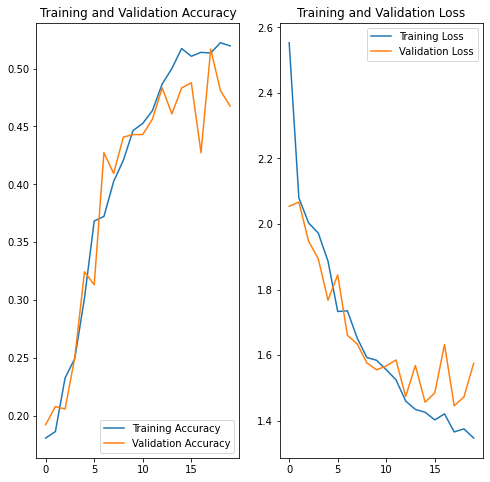

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



The graphs clearly show that the training and validation accuracies are more or less at the same levels throughtout the epochs.

Now let's try to improve the accuracy of the model by seeing if we have class imbalances, i.e. over-representation of some classes and under-representation of others. This is also a serious problem when it comes to training the model as a skewed distribution cannot help the model learn well.

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,dermatofibroma,95
2,seborrheic keratosis,77
3,basal cell carcinoma,376
4,squamous cell carcinoma,181
5,pigmented benign keratosis,462
6,actinic keratosis,114
7,vascular lesion,139
8,melanoma,438


As we can clearly see, 'pigmented benign keratosis', 'melanoma', 'basal cell carcinoma' and 'nevus' have a good number of samples for the model to work with. However, 'seborrheic keratosis', 'dermatofibroma' and 'actinic keratosis', and a couple of others are quite under-represented. Let us fix this by making the number of samples across all classes the same.

We will use the Augmentor library to create 500 samples per class and while doing so, also morph the images to ensure the model does not train repeatedly on duplicate samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC14E289280>: 100%|██████████| 500/500 [00:03<00:00, 130.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC17637BE50>: 100%|██████████| 500/500 [00:03<00:00, 142.34 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC14E230700>: 100%|██████████| 500/500 [00:03<00:00, 135.00 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FC17779F0A0>: 100%|██████████| 500/500 [00:16<00:00, 29.48 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7FC176415C10>: 100%|██████████| 500/500 [00:16<00:00, 31.17 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FC14E1959A0>: 100%|██████████| 500/500 [00:03<00:00, 141.57 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC14E2743D0>: 100%|██████████| 500/500 [00:07<00:00, 66.51 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC177663850>: 100%|██████████| 500/500 [00:03<00:00, 140.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0D0548970>: 100%|██████████| 500/500 [00:03<00:00, 138.68 Samples/s]


In [ ]:


#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)



4500


Now we have an equal distribution of samples across all classes, i.e. 9 * 500 = 4500.

Let us now modify our data files path to add these new samples.

In [ ]:



from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list
     


['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000268.jpg_125c95c8-83af-428d-9065-a8958ef4697c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000431.jpg_eee42997-a70c-4d36-be93-0bf38dbccf55.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000527.jpg_9234c84c-766e-4317-ab1f-5c114b0ba2a8.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000025.jpg_52d5b1fc-20bb-44cf-aefd-ab3bfe57bd09.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0026702.jpg_ed69434b-241a-4935-8ba0-f590f06a3873.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0027884.jpg_7adf82bc-95ac-4a8c-8cb9-1deefb02ecc8.jpg'

A quick look at all the sample classes. Although unnecessry, I'm only doing this to get a rough idea that we have 'enough' uniform disribution.

In [ ]:

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new
     

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
df2['Label'].value_counts()

nevus                         500
dermatofibroma                500
seborrheic keratosis          500
basal cell carcinoma          500
squamous cell carcinoma       500
pigmented benign keratosis    500
actinic keratosis             500
vascular lesion               500
melanoma                      500
Name: Label, dtype: int64

Again, just ensuring that we have 500 samples for each class.

Now let us recreate the training and validation datasets with the new samples.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" 

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector 
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


The training dataset now has 5392 samples compared to 1792 previously.

In [ ]:


#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)



Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


The validation dataset now has 1347 samples compared to 447 previously.

Now, let us create our 3rd model with 3 Convolutional layers and 2 Dense layers with ReLU activation and a Softmax layer. We will also use dropouts and Batch Normalization as these are proven to mitigate overfitting and make networks perform faster by normalizing the inputs.

In [ ]:
m3 = Sequential()

m3.add(rescale)

# 1st Convolutional layer
m3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
m3.add(layers.MaxPool2D(pool_size=(2,2)))
m3.add(layers.Dropout(0.25))

# 2nd Convolutional layer
m3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
m3.add(layers.MaxPool2D(pool_size=(2,2)))
m3.add(layers.Dropout(0.25))

# 3rd Convolutional layer
m3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
m3.add(layers.MaxPool2D(pool_size=(2,2)))

# Flatten out the incoming tensors into a single vector
m3.add(layers.Flatten())

# 1st Dense layer
m3.add(layers.Dense(512,activation='relu'))

# 2nd Dense layer
m3.add(layers.Dropout(0.25))

# Adding Batch Normalization
m3.add(layers.BatchNormalization())

# 3rd Dense layer
m3.add(layers.Dense(128,activation='relu'))
m3.add(layers.Dropout(0.50))
m3.add(layers.BatchNormalization())

# Final Softmax layer
m3.add(layers.Dense(len(class_names),activation='softmax'))

We now compile the 3rd model

In [ ]:
m3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

Let us now run the 3rd model with 30 epochs. As stated earlier, I am using GPU for this notebook.

In [ ]:
epochs = 30
history = m3.fit(train_ds,
                 epochs=epochs,
                 validation_data=val_ds,
                 verbose=1)

Epoch 1/30
169/169 [==============================] - 12s 49ms/step - loss: 2.4465 - accuracy: 0.1795 - val_loss: 6.4723 - val_accuracy: 0.1359
Epoch 2/30
169/169 [==============================] - 8s 47ms/step - loss: 1.8901 - accuracy: 0.2999 - val_loss: 3.5386 - val_accuracy: 0.1477
Epoch 3/30
169/169 [==============================] - 8s 48ms/step - loss: 1.6898 - accuracy: 0.3583 - val_loss: 1.7751 - val_accuracy: 0.3059
Epoch 4/30
169/169 [==============================] - 8s 47ms/step - loss: 1.5295 - accuracy: 0.4230 - val_loss: 1.6898 - val_accuracy: 0.3318
Epoch 5/30
169/169 [==============================] - 8s 46ms/step - loss: 1.4401 - accuracy: 0.4551 - val_loss: 1.6035 - val_accuracy: 0.3801
Epoch 6/30
169/169 [==============================] - 8s 46ms/step - loss: 1.3824 - accuracy: 0.4737 - val_loss: 1.5635 - val_accuracy: 0.3905
Epoch 7/30
169/169 [==============================] - 8s 47ms/step - loss: 1.3113 - accuracy: 0.5043 - val_loss: 1.4088 - val_accuracy: 0.459

After 30 epochs, the training accuracy is 86.7% and the validation accuracy is 77.9%. This is a major improvement over the previous models, as this indicates higher validation accuracy and better control of overfitting (the gap between the training and validation accuracies is vastly reduced now.

Note that this improvement is not only due to the fact that we used 30 epochs in this run compared to 20 for the previous models. If look at the 20th epoch, the training accuracy is 75.8% and the validation accuracy is 71.9%. And the accuracies are steadily increases every new epoch.

This proves that it is not only the increase in the number of epochs used but also, and majorly, because of the augmentation strategy used to create an evenly distributed dataset set with a uniform number of samples across all classes, that helped increase the overall accuracy of the model.

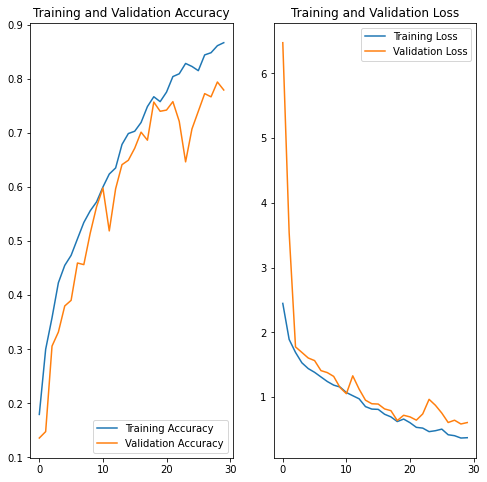

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Visually too, the training and validation accuracies are closer together across all epochs and are at pretty high numbers throughout.

# Summary of findings:
=============================

## 1) Importance of sample diversity: 
### As proven in this exercise it is of utmost importance that the model receives **enough data, with enough variations, and uniform distribution across all classes** in order to train itself to high accuracy. Tuning strategies like dropouts and Batch Normalization can only improve the accuracy to a certain extent if the data the model has to work with is limited and skewed.

  
## 2) Plan your runs optimally:
### Running multiple epochs is computationally expensive and time consuming. In an ideal world, we would be using high-end infrastructure like GPUs and TPUs to train our models, but, as we know, these are very expensive. Remember, **syntax errors and run-time errors also cost computational units**. Therefore, it is imperative that we run through our code with a fine comb, perform every possible syntax check and also ensure that the code is as we want it to be, by running it locally, before we run it on a GPU or a TPU.
  

## 3) How many epochs to run:
### At first sight it may seem obvious that the more the epochs, the better the model accuracy. This is not necessarily true because after a certain number of epochs, the model might reach it's optimum accuracy and beyond that the accuracy might even reduce. And then there is the fact of computational costs, i.e., more epochs = more cost. Fortunately, we can capture the run-time statistics of every epoch, and we can clearly see at which epoch the accuracy is highest, beyond which the accuracy dwindles. We can then finalize the number of epochs to that epoch number.